# Ejercicio de riesgo de mercado: Problema de regresión

Queremos conocer el valor de un activo (viviendas) a partir de los datos que describen al activo para conocer el estado actual del mercado de viviendas en un sector específico:
* lotSize: Tamaño del lote donde está ubicada la vivienda
* age: Tiempo de antigüedad de la vivienda
* landValue: Valor del terreno donde está ubicada la vivienda (dólares)
* livingArea: Área habitable de la vivienda
* pctCollege: Relación de centros de educación en la zona de ubicación de la vivienda
* fireplaces: Cantidad de chimeneas de la vivienda
* bedrooms: Cantidad de dormitorios de la vivienda
* bathrooms: Cantidad de baños de la vivienda
* rooms: Cantidad de habitaciones que tiene la vivienda
* heating: Tipo de calefacción de la vivienda
* fuel: Tipo de combustible de la calefacción
* sewer: Tipo de alcantarillado de la vivienda
* waterfront: Si está a la vista de un lago
* newConstruction: Si es o no vivienda nueva
* centralAir: Si el aire acondicionado es centralizado o no
* price: Precio de la vivienda

## Librerías

In [1]:
#Advertencias
import warnings
warnings.filterwarnings('ignore')

#tratamiento de datos
import pandas as pd
import numpy as np

#Gráficos
import matplotlib.pyplot as plt
import seaborn as sb

#Preparación de datos
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import make_column_selector
from sklearn import set_config

#Modelado
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor

#Búsqueda de hiperparámetros
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

#Evaluación
from sklearn.metrics import r2_score, mean_squared_error

## Cargar / Importar Datos

In [2]:
url = "https://raw.githubusercontent.com/JoaquinAmatRodrigo/Estadistica-machine-learning-python/master/data/SaratogaHouses.csv"
datos = pd.read_csv(url)
datos.head()

,price,lotSize,age,landValue,livingArea,pctCollege,bedrooms,fireplaces,bathrooms,rooms,heating,fuel,sewer,waterfront,newConstruction,centralAir
0,132500,0.09,42,50000,906,35,2,1,1.0,5,electric,electric,septic,No,No,No
1,181115,0.92,0,22300,1953,51,3,0,2.5,6,hot water/steam,gas,septic,No,No,No
2,109000,0.19,133,7300,1944,51,4,1,1.0,8,hot water/steam,gas,public/commercial,No,No,No
3,155000,0.41,13,18700,1944,51,3,1,1.5,5,hot air,gas,septic,No,No,No
4,86060,0.11,0,15000,840,51,2,0,1.0,3,hot air,gas,public/commercial,No,Yes,Yes


In [3]:
datos.tail()

,price,lotSize,age,landValue,livingArea,pctCollege,bedrooms,fireplaces,bathrooms,rooms,heating,fuel,sewer,waterfront,newConstruction,centralAir
1723,289000,0.38,32,24200,2310,61,5,1,2.5,11,hot water/steam,gas,public/commercial,No,No,No
1724,285000,0.94,37,36200,2564,61,4,1,2.5,11,hot water/steam,gas,public/commercial,No,No,No
1725,194900,0.39,9,20400,1099,51,2,0,1.0,3,hot air,gas,public/commercial,No,No,No
1726,125000,0.24,48,16800,1225,51,3,1,1.0,7,hot air,gas,public/commercial,No,No,No
1727,111300,0.59,86,26000,1959,51,3,0,1.0,6,hot air,gas,septic,No,No,No


## Exploración de datos

In [4]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1728 entries, 0 to 1727
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   price            1728 non-null   int64  
 1   lotSize          1728 non-null   float64
 2   age              1728 non-null   int64  
 3   landValue        1728 non-null   int64  
 4   livingArea       1728 non-null   int64  
 5   pctCollege       1728 non-null   int64  
 6   bedrooms         1728 non-null   int64  
 7   fireplaces       1728 non-null   int64  
 8   bathrooms        1728 non-null   float64
 9   rooms            1728 non-null   int64  
 10  heating          1728 non-null   object 
 11  fuel             1728 non-null   object 
 12  sewer            1728 non-null   object 
 13  waterfront       1728 non-null   object 
 14  newConstruction  1728 non-null   object 
 15  centralAir       1728 non-null   object 
dtypes: float64(2), int64(8), object(6)
memory usage: 216.1+ KB


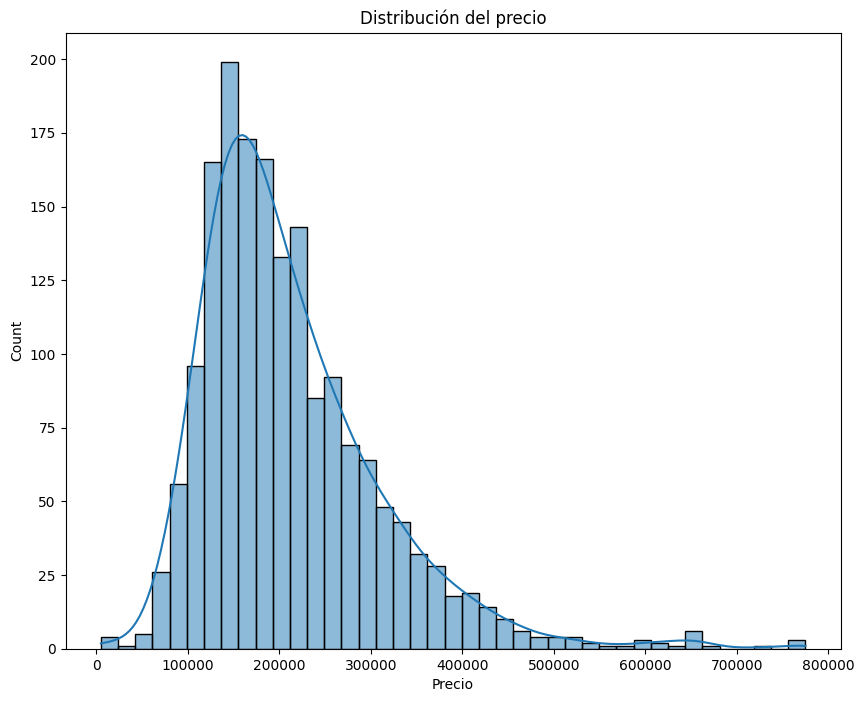

In [5]:
#Histograma de frecuencias para el precio
plt.figure(figsize = (10,8))
sb.histplot(data = datos, x = 'price', kde = True)
plt.title('Distribución del precio')
plt.xlabel('Precio')
plt.show()

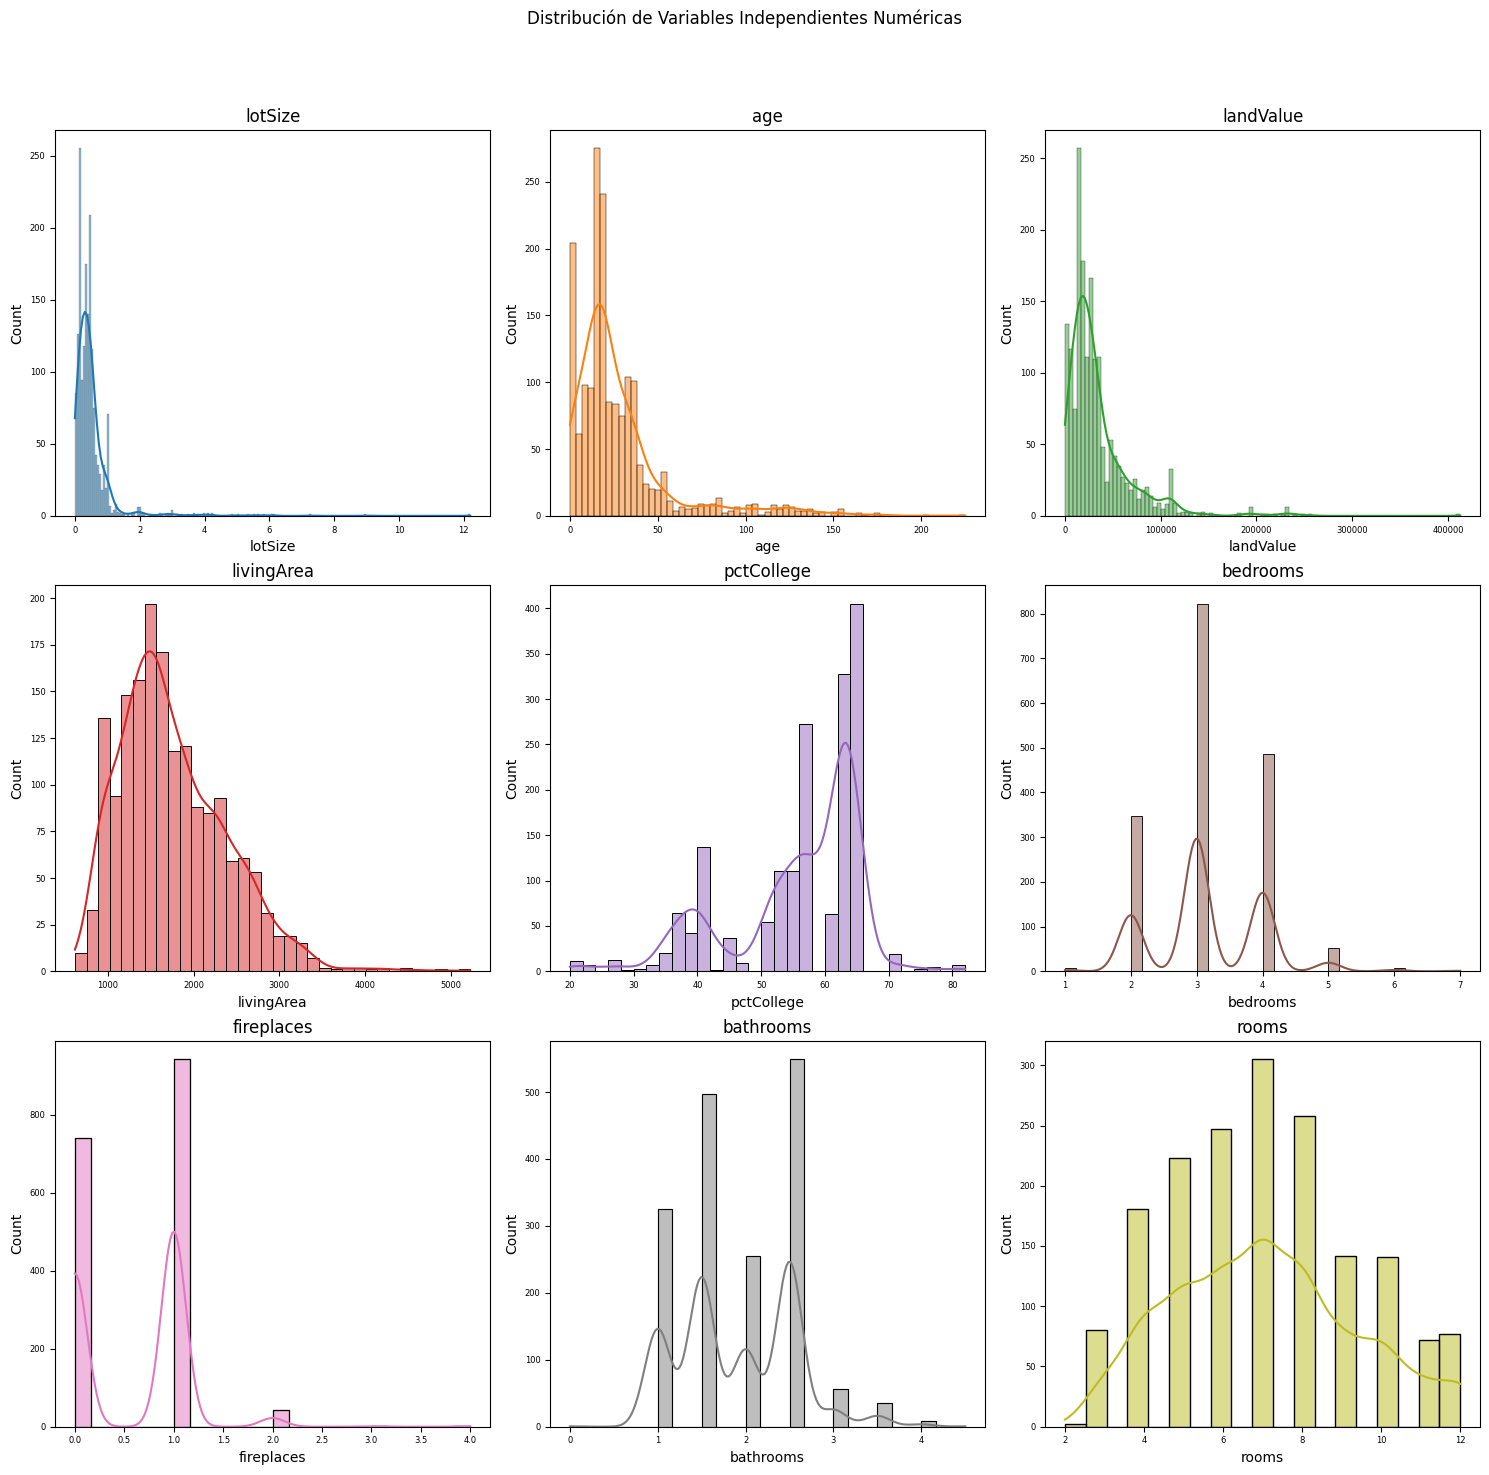

In [6]:
fig, ax = plt.subplots(3, 3, figsize = (15,15))
ax = ax.flat
numCol = datos.select_dtypes(include = ["float64", "int64"]).columns
numCol = numCol.drop("price")
for i, col in enumerate(numCol):
    sb.histplot(data = datos,
                x = col,
                kde = True, 
                color = (list(plt.rcParams['axes.prop_cycle'])*2)[i]['color'],
                ax = ax[i]
               )
    ax[i].set_title(col)
    ax[i].tick_params(labelsize = 6)
    
fig.tight_layout()
plt.subplots_adjust(top = 0.9)
plt.suptitle('Distribución de Variables Independientes Numéricas')
plt.show()

In [7]:
datos.describe()

,price,lotSize,age,landValue,livingArea,pctCollege,bedrooms,fireplaces,bathrooms,rooms
count,1728.000000,1728.000000,1728.000000,1728.000000,1728.000000,1728.000000,1728.000000,1728.000000,1728.000000,1728.000000
mean,211966.705440,0.500214,27.916088,34557.187500,1754.975694,55.567708,3.154514,0.601852,1.900174,7.041667
std,98441.391015,0.698680,29.209988,35021.168056,619.935553,10.333581,0.817351,0.556102,0.658352,2.316453
min,5000.000000,0.000000,0.000000,200.000000,616.000000,20.000000,1.000000,0.000000,0.000000,2.000000
25%,145000.000000,0.170000,13.000000,15100.000000,1300.000000,52.000000,3.000000,0.000000,1.500000,5.000000
50%,189900.000000,0.370000,19.000000,25000.000000,1634.500000,57.000000,3.000000,1.000000,2.000000,7.000000
75%,259000.000000,0.540000,34.000000,40200.000000,2137.750000,64.000000,4.000000,1.000000,2.500000,8.250000
max,775000.000000,12.200000,225.000000,412600.000000,5228.000000,82.000000,7.000000,4.000000,4.500000,12.000000


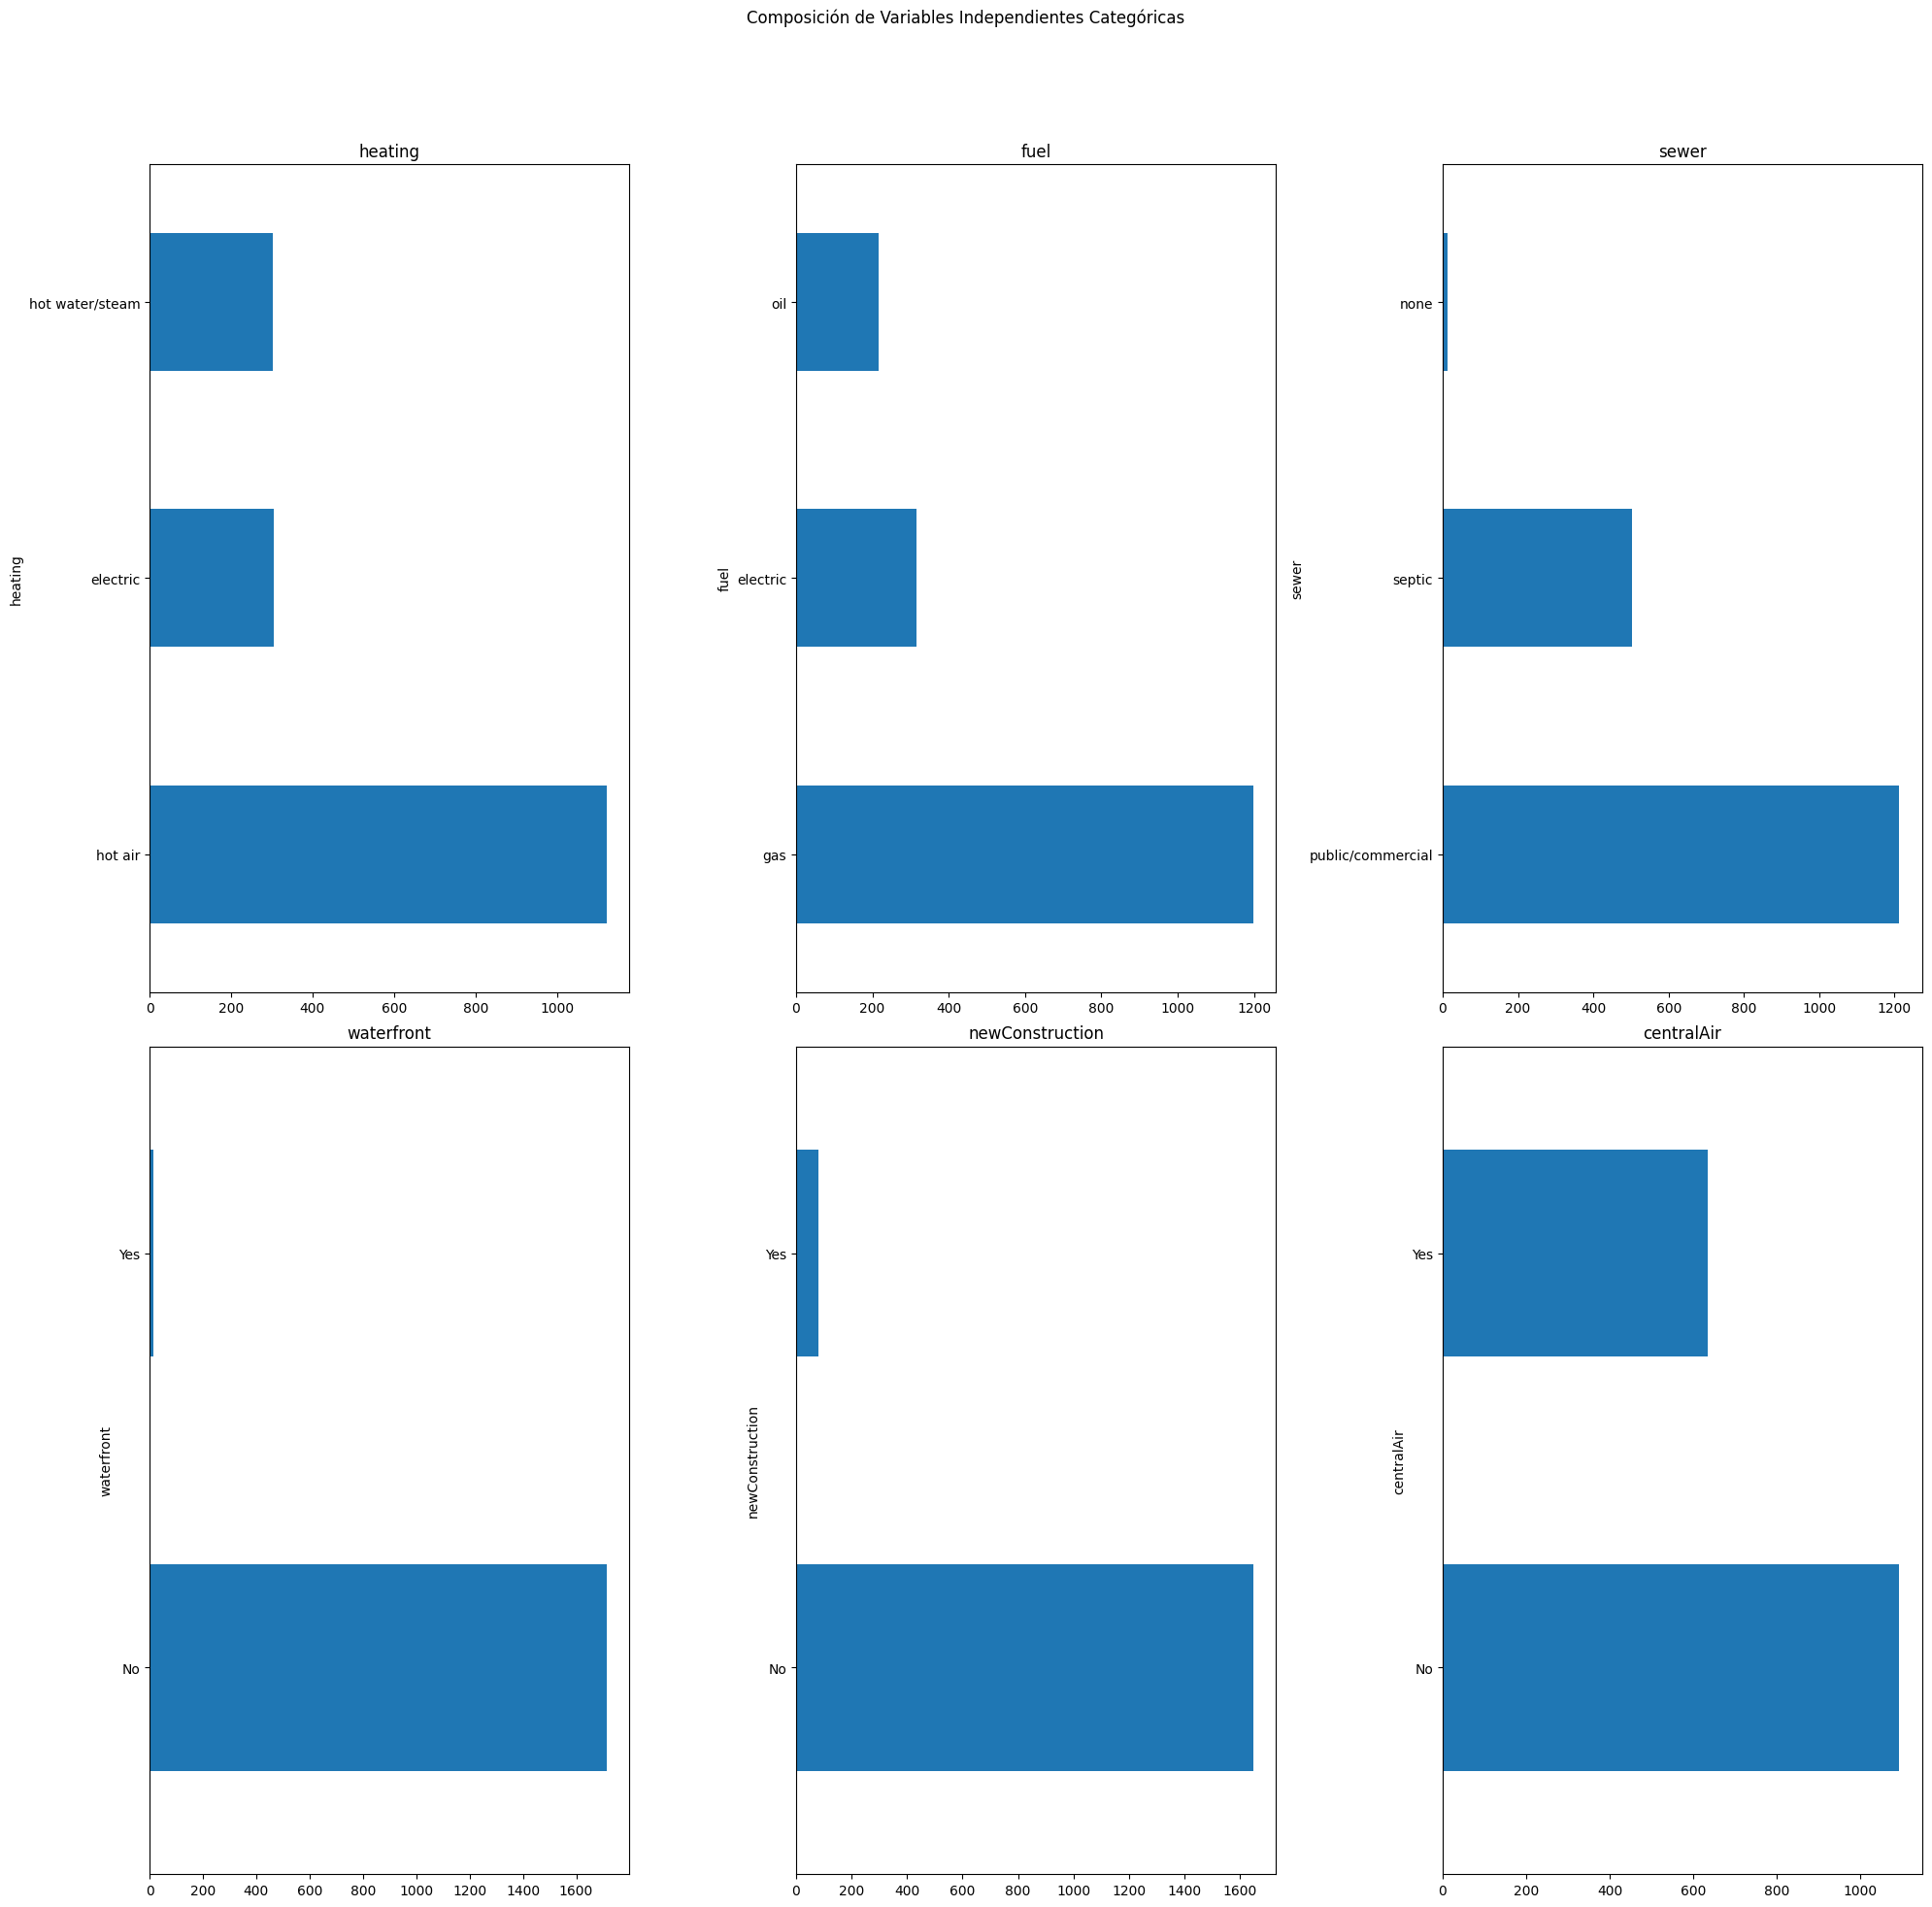

In [8]:
fig, ax = plt.subplots(2, 3, figsize = (20, 20))
ax = ax.flat
catCol = datos.select_dtypes(include = ['object']).columns
for i, col in enumerate(catCol):
    datos[col].value_counts().plot.barh(ax = ax[i])
    ax[i].set_title(col)
    
fig.tight_layout()
plt.subplots_adjust(top = 0.9)
plt.suptitle('Composición de Variables Independientes Categóricas')
plt.show()

In [41]:
datos.describe(include = ['object'])

,heating,fuel,sewer,centralAir
count,1728,1728,1728,1728
unique,3,3,3,2
top,hot air,gas,public/commercial,No
freq,1121,1197,1213,1093


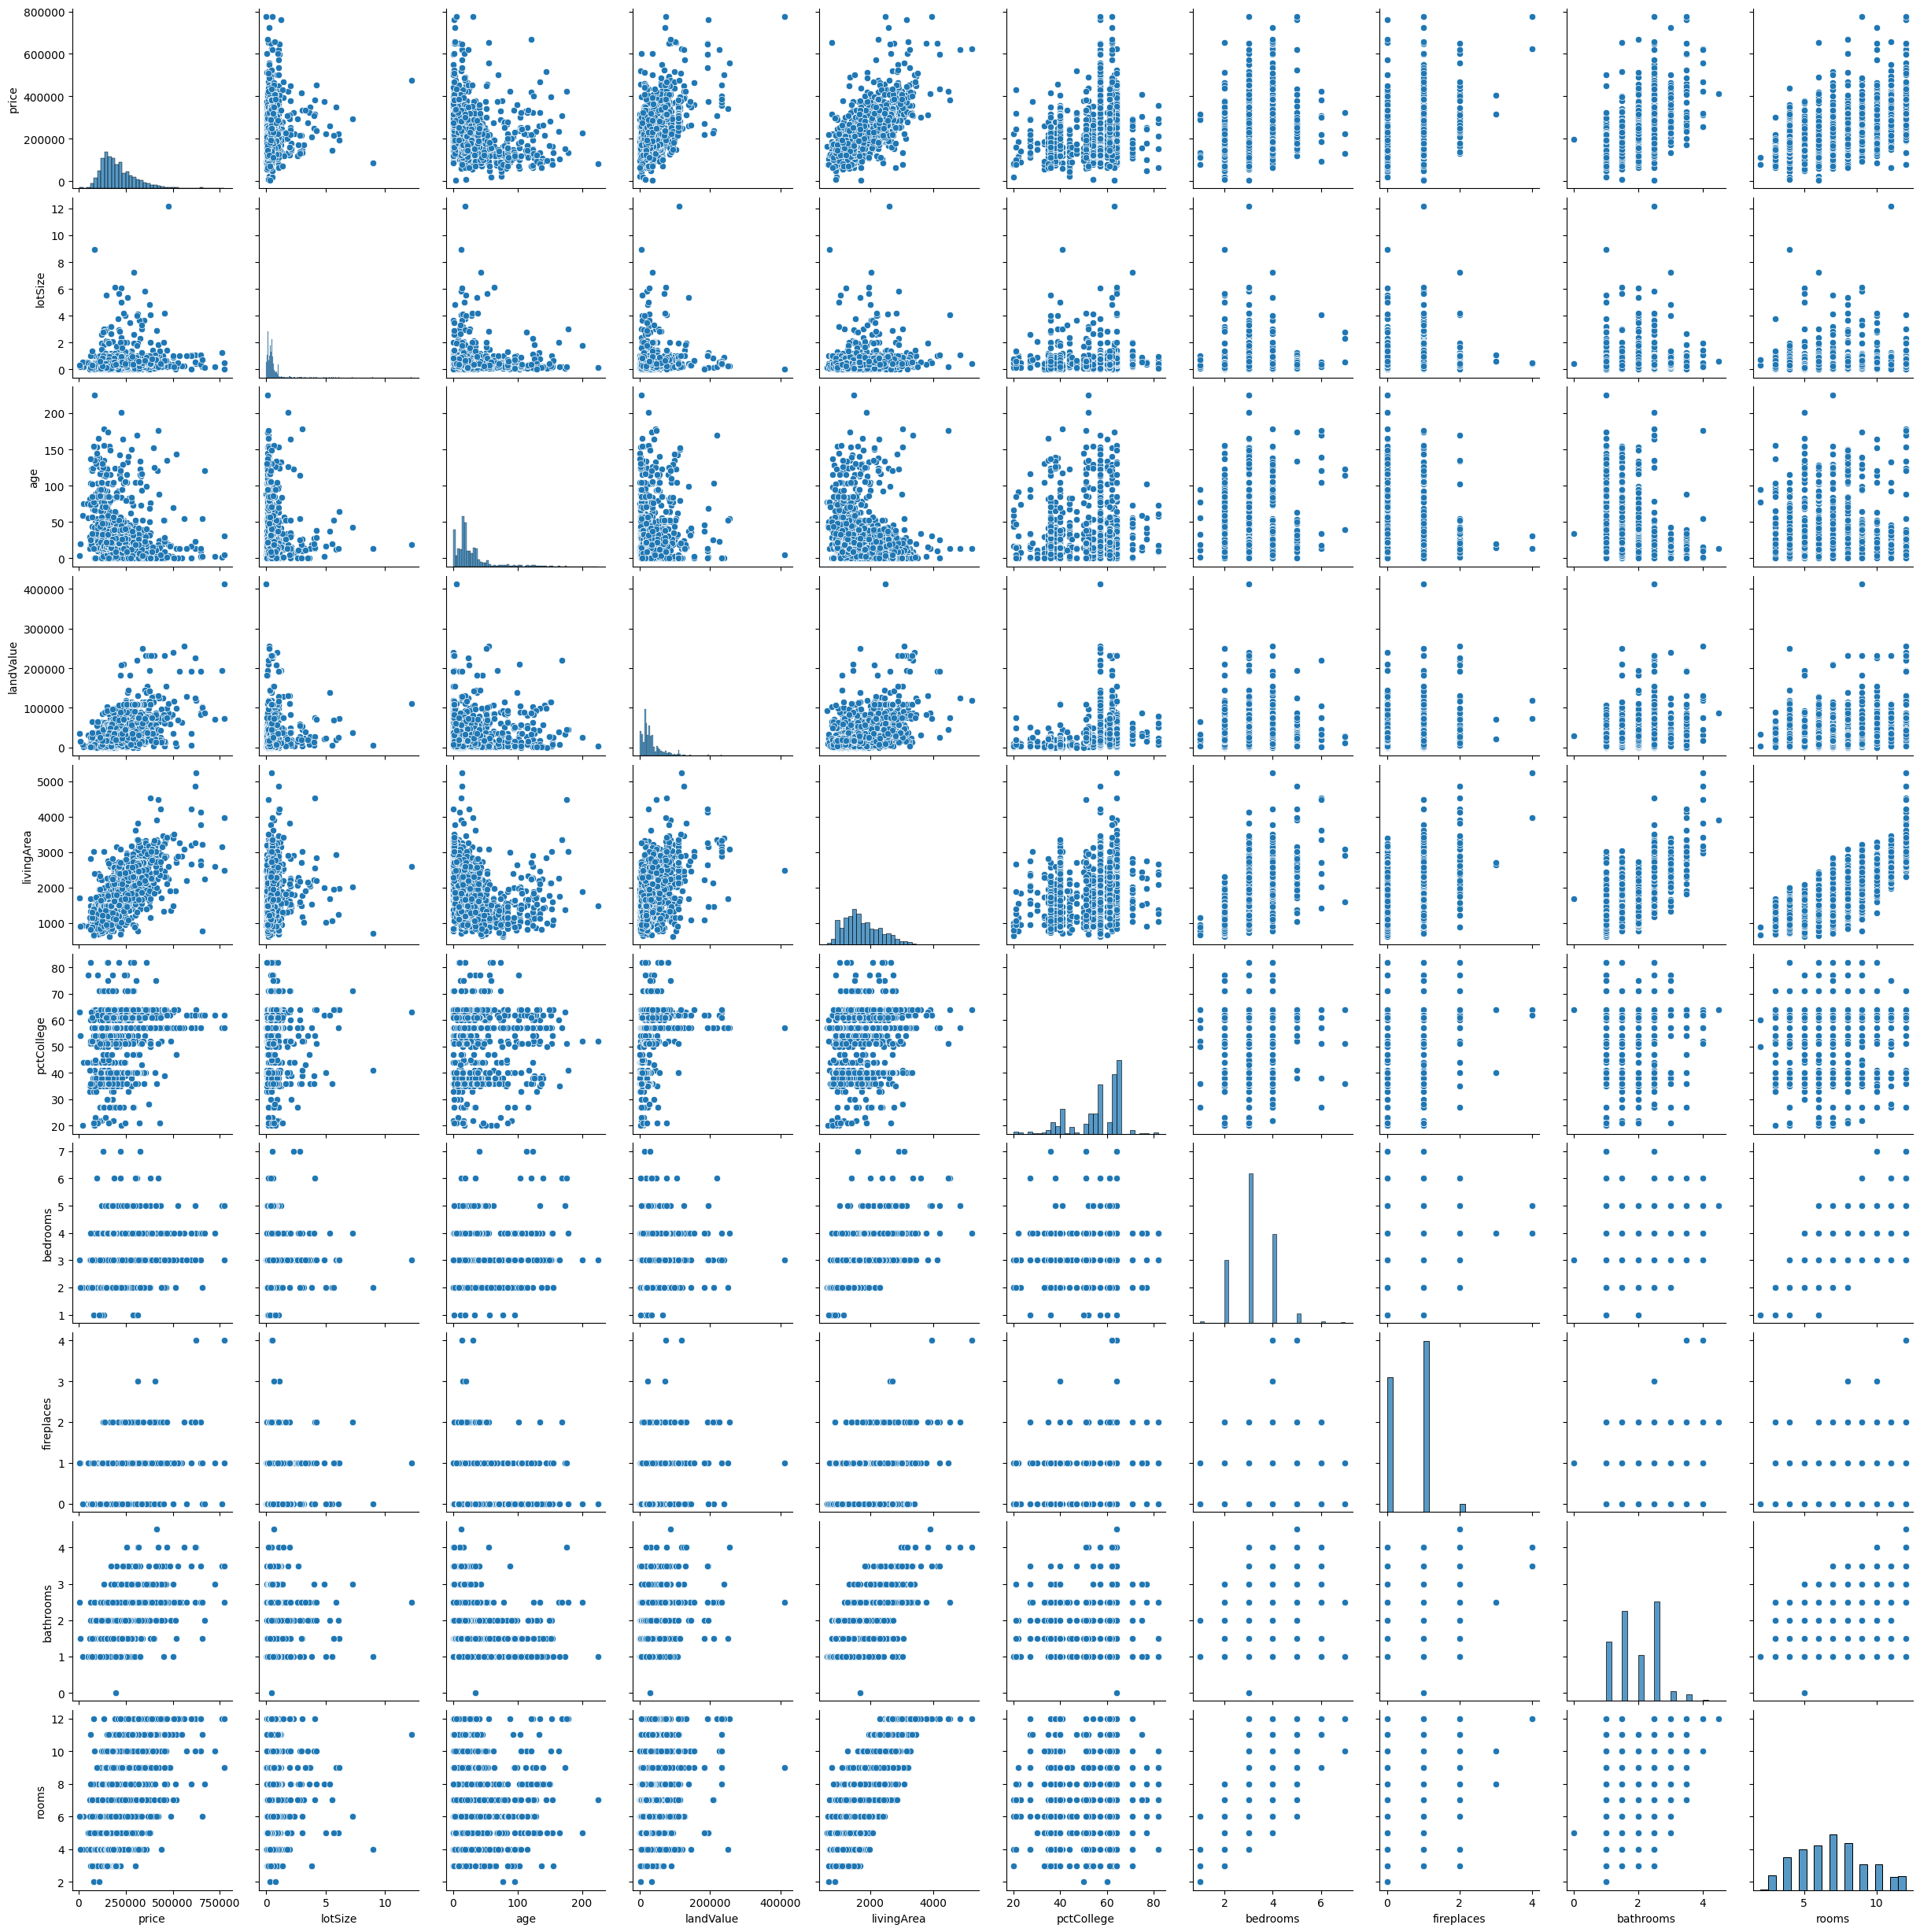

In [42]:
sb.pairplot(data = datos)
plt.show()

## Preparación de los datos

In [47]:
#Eliminar las variables waterfront y newConstruction
datos.drop(['waterfront', 'newConstruction'], axis = 1, inplace = True)
datos.head()

,price,lotSize,age,landValue,livingArea,pctCollege,bedrooms,fireplaces,bathrooms,rooms,heating,fuel,sewer,centralAir
0,132500,0.09,42,50000,906,35,2,1,1.0,5,electric,electric,septic,No
1,181115,0.92,0,22300,1953,51,3,0,2.5,6,hot water/steam,gas,septic,No
2,109000,0.19,133,7300,1944,51,4,1,1.0,8,hot water/steam,gas,public/commercial,No
3,155000,0.41,13,18700,1944,51,3,1,1.5,5,hot air,gas,septic,No
4,86060,0.11,0,15000,840,51,2,0,1.0,3,hot air,gas,public/commercial,Yes


In [48]:
# Diseñar un procesador de datos
numCols = datos.select_dtypes(include = ['float64','int64']).columns.to_list()
catCols = datos.select_dtypes(include = ['object']).columns.to_list()
numTransformer = Pipeline(steps = [('scaler', MinMaxScaler())])
catTransformer = Pipeline(steps = [('onehot', OneHotEncoder(handle_unknown = 'ignore'))])
preprocesador = ColumnTransformer(transformers = [
    ('num', numTransformer, numCols),
    ('cat', catTransformer, catCols)],
                                  remainder = 'passthrough')
set_config(display = 'diagram')
preprocesador

ColumnTransformer(remainder='passthrough',
                  transformers=[('num',
                                 Pipeline(steps=[('scaler', MinMaxScaler())]),
                                 ['price', 'lotSize', 'age', 'landValue',
                                  'livingArea', 'pctCollege', 'bedrooms',
                                  'fireplaces', 'bathrooms', 'rooms']),
                                ('cat',
                                 Pipeline(steps=[('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['heating', 'fuel', 'sewer', 'centralAir'])])

In [49]:
datosPre = preprocesador.fit_transform(datos)
codCat = preprocesador.named_transformers_['cat']['onehot'].get_feature_names_out(catCols)
labels = np.concatenate([numCols, codCat])
datosPro = pd.DataFrame(datosPre, columns = labels)
datosPro.head()

,price,lotSize,age,landValue,livingArea,pctCollege,bedrooms,fireplaces,bathrooms,rooms,...,heating_hot air,heating_hot water/steam,fuel_electric,fuel_gas,fuel_oil,sewer_none,sewer_public/commercial,sewer_septic,centralAir_No,centralAir_Yes
0,0.165584,0.007377,0.186667,0.120757,0.062879,0.241935,0.166667,0.25,0.222222,0.3,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
1,0.228721,0.075410,0.000000,0.053589,0.289896,0.500000,0.333333,0.00,0.555556,0.4,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
2,0.135065,0.015574,0.591111,0.017216,0.287944,0.500000,0.500000,0.25,0.222222,0.6,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
3,0.194805,0.033607,0.057778,0.044859,0.287944,0.500000,0.333333,0.25,0.333333,0.3,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
4,0.105273,0.009016,0.000000,0.035887,0.048569,0.500000,0.166667,0.00,0.222222,0.1,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0


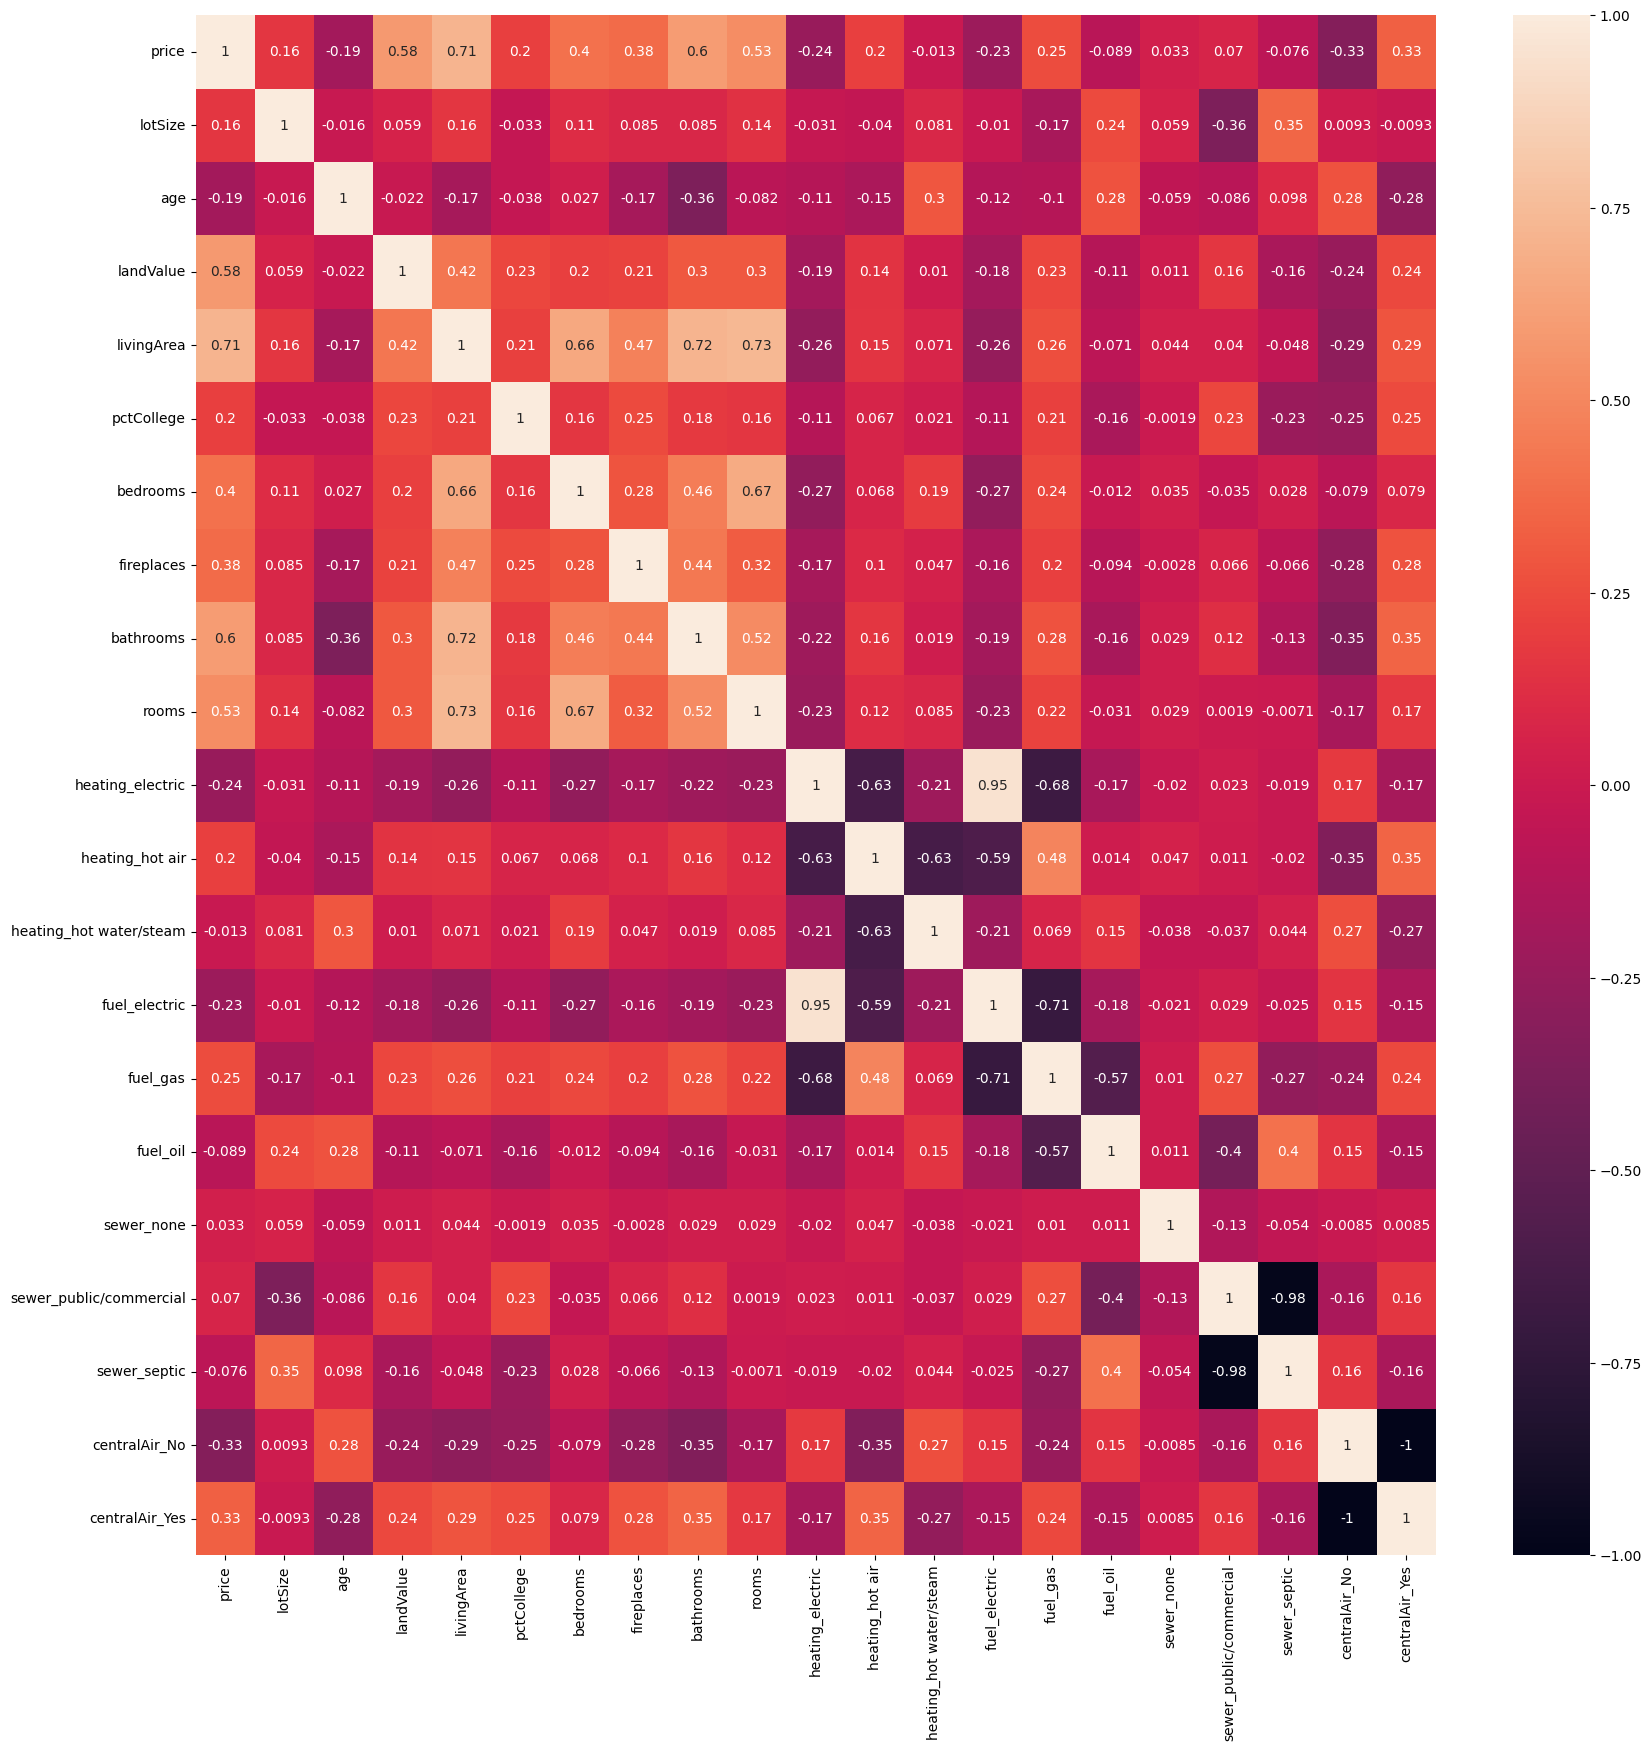

In [50]:
plt.figure(figsize = (20,20))

sb.heatmap(datosPro.corr(), annot = True)

plt.show()

In [51]:
#Separar x de y

X = datosPro.drop("price", axis = 1)

y = datosPro[["price"]]

In [52]:
#Construir conjuntos de entrenamiento y prueba
x_train, x_test, y_train, y_test = train_test_split(X, y, train_size = 0.7, random_state = 123)

## Modelado

In [53]:
modelo_1 = LinearRegression()
modelo_2 = SVR()
modelo_3 = MLPRegressor()
modelo_4 = DecisionTreeRegressor()

In [54]:
modelo_1.fit(x_train, y_train)
modelo_2.fit(x_train, y_train)
modelo_3.fit(x_train, y_train)
modelo_4.fit(x_train, y_train)

DecisionTreeRegressor()

## Evaluación

### Regresión Lineal

Las métricas de entrenamiento para la Regresión Lineal son: R2 = 0.6537740267981825, RMSE = 0.07427190809491348
Las métricas de prueba para la Regresión Lineal son: R2 = 0.573871203778058, RMSE = 0.08578406526719823


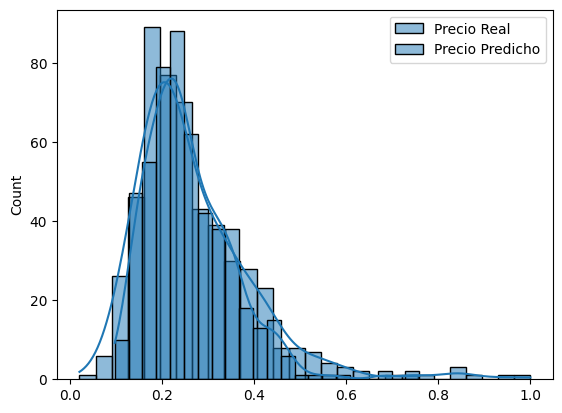

In [55]:
ypredEnt_1 = modelo_1.predict(x_train)
ypredPru_1 = modelo_1.predict(x_test)
r2Entrenamiento_1 = r2_score(y_train, ypredEnt_1)
rmseEntrenamiento_1 = mean_squared_error(y_train, ypredEnt_1, squared = False)
r2Prueba_1 = r2_score(y_test, ypredPru_1)
rmsePrueba_1 = mean_squared_error(y_test, ypredPru_1, squared = False)
print(f'Las métricas de entrenamiento para la Regresión Lineal son: R2 = {r2Entrenamiento_1}, RMSE = {rmseEntrenamiento_1}')
print(f'Las métricas de prueba para la Regresión Lineal son: R2 = {r2Prueba_1}, RMSE = {rmsePrueba_1}')
sb.histplot(y_test, label = 'Precio Real', color = 'blue', kde = True)
sb.histplot(ypredPru_1, label = 'Precio Predicho', color = 'orange', kde = True)
plt.legend()
plt.show()

### Maquina de soporte vectorial

Las métricas de entrenamiento para la máquina de soporte vectorial son: R2 = 0.69577435644399, RMSE = 0.06962138655138166
Las métricas de prueba para la máquina de soporte vectorial son: R2 = 0.5475139216762088, RMSE = 0.08839725776931892


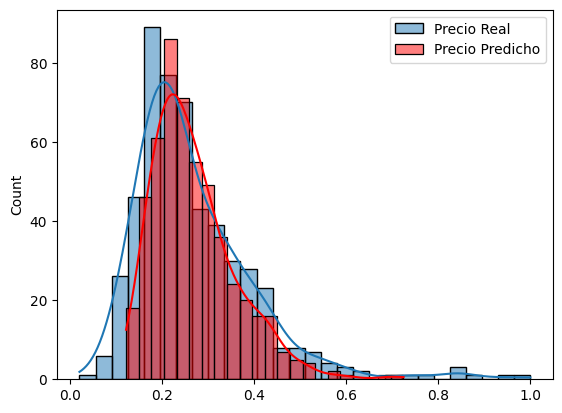

In [56]:
ypredEnt_2 = modelo_2.predict(x_train)
ypredPru_2 = modelo_2.predict(x_test)
r2Entrenamiento_2 = r2_score(y_train, ypredEnt_2)
rmseEntrenamiento_2 = mean_squared_error(y_train, ypredEnt_2, squared = False)
r2Prueba_2 = r2_score(y_test, ypredPru_2)
rmsePrueba_2 = mean_squared_error(y_test, ypredPru_2, squared = False)
print(f'Las métricas de entrenamiento para la máquina de soporte vectorial son: R2 = {r2Entrenamiento_2}, RMSE = {rmseEntrenamiento_2}')
print(f'Las métricas de prueba para la máquina de soporte vectorial son: R2 = {r2Prueba_2}, RMSE = {rmsePrueba_2}')
sb.histplot(y_test, label = 'Precio Real', color = 'blue', kde = True)
sb.histplot(ypredPru_2, label = 'Precio Predicho', color = 'red', kde = True)
plt.legend()
plt.show()

### Red neuronal artificial

Las métricas de entrenamiento para la red neuronal artificial son: R2 = 0.5898813972105407, RMSE = 0.0808350094817216
Las métricas de prueba para la red neuronal artificial son: R2 = 0.45609709458711634, RMSE = 0.09691631016629933


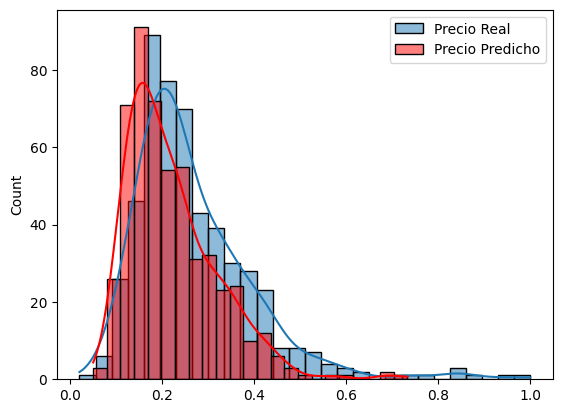

In [57]:
ypredEnt_3 = modelo_3.predict(x_train)
ypredPru_3 = modelo_3.predict(x_test)
r2Entrenamiento_3 = r2_score(y_train, ypredEnt_3)
rmseEntrenamiento_3 = mean_squared_error(y_train, ypredEnt_3, squared = False)
r2Prueba_3 = r2_score(y_test, ypredPru_3)
rmsePrueba_3 = mean_squared_error(y_test, ypredPru_3, squared = False)
print(f'Las métricas de entrenamiento para la red neuronal artificial son: R2 = {r2Entrenamiento_3}, RMSE = {rmseEntrenamiento_3}')
print(f'Las métricas de prueba para la red neuronal artificial son: R2 = {r2Prueba_3}, RMSE = {rmsePrueba_3}')
sb.histplot(y_test, label = 'Precio Real', color = 'blue', kde = True)
sb.histplot(ypredPru_3, label = 'Precio Predicho', color = 'red', kde = True)
plt.legend()
plt.show()

### Árbol de decisión

Las métricas de entrenamiento para la Regresión Lineal son: R2 = 1.0, RMSE = 0.0
Las métricas de prueba para la Regresión Lineal son: R2 = 0.3628033400295556, RMSE = 0.10489938139940388


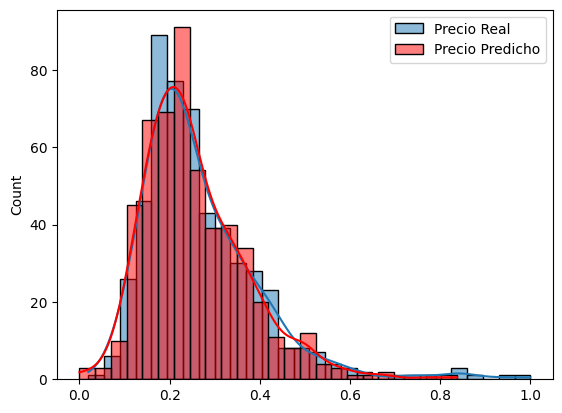

In [58]:
ypredEnt_4 = modelo_4.predict(x_train)
ypredPru_4 = modelo_4.predict(x_test)
r2Entrenamiento_4 = r2_score(y_train, ypredEnt_4)
rmseEntrenamiento_4 = mean_squared_error(y_train, ypredEnt_4, squared = False)
r2Prueba_4 = r2_score(y_test, ypredPru_4)
rmsePrueba_4 = mean_squared_error(y_test, ypredPru_4, squared = False)
print(f'Las métricas de entrenamiento para la Regresión Lineal son: R2 = {r2Entrenamiento_4}, RMSE = {rmseEntrenamiento_4}')
print(f'Las métricas de prueba para la Regresión Lineal son: R2 = {r2Prueba_4}, RMSE = {rmsePrueba_4}')
sb.histplot(y_test, label = 'Precio Real', color = 'blue', kde = True)
sb.histplot(ypredPru_4, label = 'Precio Predicho', color = 'red', kde = True)
plt.legend()
plt.show()

In [23]:
modelo_2 = SVR()
modelo_3 = MLPRegressor()
modelo_4 = DecisionTreeRegressor()

## Búsqueda de hiperparámetros

### Máquina de soporte vectorial

Búsqueda exhaustiva

In [24]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
              'kernel':['linear', 'poly', 'rbf', 'sigmoid'],
              'degree':[2,3,4]}

In [25]:
regresor = GridSearchCV(modelo_2, param_grid = param_grid, cv = 3)
regresor.fit(x_train, y_train)

GridSearchCV(cv=3, estimator=SVR(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'degree': [2, 3, 4],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']})

In [26]:
validacion = pd.concat([pd.DataFrame(regresor.cv_results_['params']),
                       pd.DataFrame(regresor.cv_results_['mean_test_score'], 
                                   columns = ['R2'])], axis = 1)
validacion.sort_values('R2', ascending = False)

,C,degree,kernel,R2
36,1.0,2,linear,6.235551e-01
44,1.0,4,linear,6.235551e-01
40,1.0,3,linear,6.235551e-01
52,10.0,3,linear,6.222772e-01
48,10.0,2,linear,6.222772e-01
...,...,...,...,...
55,10.0,3,sigmoid,-7.659464e+05
51,10.0,2,sigmoid,-7.659464e+05
67,100.0,3,sigmoid,-8.456223e+07
63,100.0,2,sigmoid,-8.456223e+07


In [27]:
modelo_SVR_definitivo = regresor.best_estimator_
pred_SVR_prueba = modelo_SVR_definitivo.predict(x_test)
r2_score(y_test, pred_SVR_prueba)

0.5591342687620755

Búsqueda aleatoria

In [28]:
regresor = RandomizedSearchCV(modelo_2, cv = 3, param_distributions = param_grid, n_iter = 10)
regresor.fit(x_train, y_train)

RandomizedSearchCV(cv=3, estimator=SVR(),
                   param_distributions={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                                        'degree': [2, 3, 4],
                                        'kernel': ['linear', 'poly', 'rbf',
                                                   'sigmoid']})

In [29]:
validacion = pd.concat([pd.DataFrame(regresor.cv_results_['params']),
                       pd.DataFrame(regresor.cv_results_['mean_test_score'], 
                                   columns = ['R2'])], axis = 1)
validacion.sort_values('R2', ascending = False)

,kernel,degree,C,R2
3,linear,2,1.000,0.623555
7,poly,3,0.100,0.609840
1,rbf,3,10.000,0.588079
0,poly,3,1.000,0.584000
4,linear,2,0.010,0.502571
8,poly,4,10.000,0.487702
9,poly,3,0.001,0.379547
6,sigmoid,3,0.001,0.057292
5,sigmoid,4,1.000,-7669.136732
2,sigmoid,3,10.000,-765946.382518


### Red neuronal artificial

Búsqueda exhaustiva

In [30]:
param_grid = {'hidden_layer_sizes': [(2,3,4), (3,6,9), (8,5,3), (5,4,9), (100,)],
              'learning_rate_init':[0.001, 0.01, 0.1, 1, 10, 100],
              'max_iter':[50,100,200,300,400],
              'activation':['logistic', 'tanh', 'relu']
             }

In [32]:
regresor = GridSearchCV(modelo_3, param_grid = param_grid, cv = 3)
regresor.fit(x_train, y_train)

GridSearchCV(cv=3, estimator=MLPRegressor(),
             param_grid={'activation': ['logistic', 'tanh', 'relu'],
                         'hidden_layer_sizes': [(2, 3, 4), (3, 6, 9), (8, 5, 3),
                                                (5, 4, 9), (100,)],
                         'learning_rate_init': [0.001, 0.01, 0.1, 1, 10, 100],
                         'max_iter': [50, 100, 200, 300, 400]})

In [33]:
validacion = pd.concat([pd.DataFrame(regresor.cv_results_['params']),
                       pd.DataFrame(regresor.cv_results_['mean_test_score'], 
                                   columns = ['R2'])], axis = 1)
validacion.sort_values('R2', ascending = False)

,activation,hidden_layer_sizes,learning_rate_init,max_iter,R2
271,tanh,"(100,)",0.001,100,6.154160e-01
187,tanh,"(3, 6, 9)",0.010,200,6.142817e-01
272,tanh,"(100,)",0.001,200,6.044682e-01
273,tanh,"(100,)",0.001,300,6.037626e-01
399,relu,"(5, 4, 9)",0.010,400,6.029410e-01
...,...,...,...,...,...
326,relu,"(2, 3, 4)",100.000,100,-1.745295e+12
325,relu,"(2, 3, 4)",100.000,50,-1.782202e+12
415,relu,"(5, 4, 9)",100.000,50,-2.830540e+12
419,relu,"(5, 4, 9)",100.000,400,-4.882662e+12


In [34]:
modelo_SVR_definitivo = regresor.best_estimator_
pred_SVR_prueba = modelo_SVR_definitivo.predict(x_test)
r2_score(y_test, pred_SVR_prueba)

0.5731869763028328

## Conclusiones

En base a los resultados de las pruebas, los mejores modelos fueron la regresión logística y la red neuronal artificial con
búsqueda exahustiva de parámetros. La diferencia de precisión de ambos modelos es despreciable.